In [60]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [17]:
file = "https://raw.githubusercontent.com/gnapoles/data-mining-course/main/diabetes.csv"
data = pd.read_csv(file)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [18]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [19]:
data.value_counts("Outcome")

Outcome
0    500
1    268
Name: count, dtype: int64

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#building models without hyperparameter tuning
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_tree = tree.predict(X_test)


randforest = RandomForestClassifier(random_state=42)
randforest.fit(X_train, y_train)

y_forest = randforest.predict(X_test)

print("F1 score of decision tree:", f1_score(y_test, y_tree))
print("F1 score of random forest:", f1_score(y_test, y_forest))

F1 score of decision tree: 0.6722689075630253
F1 score of random forest: 0.6126126126126126


In [21]:
#features deemed of low importance for a suboptimal model might be important for a well fitted model
#evaluate the classifier's performance using a hold out set, or CV

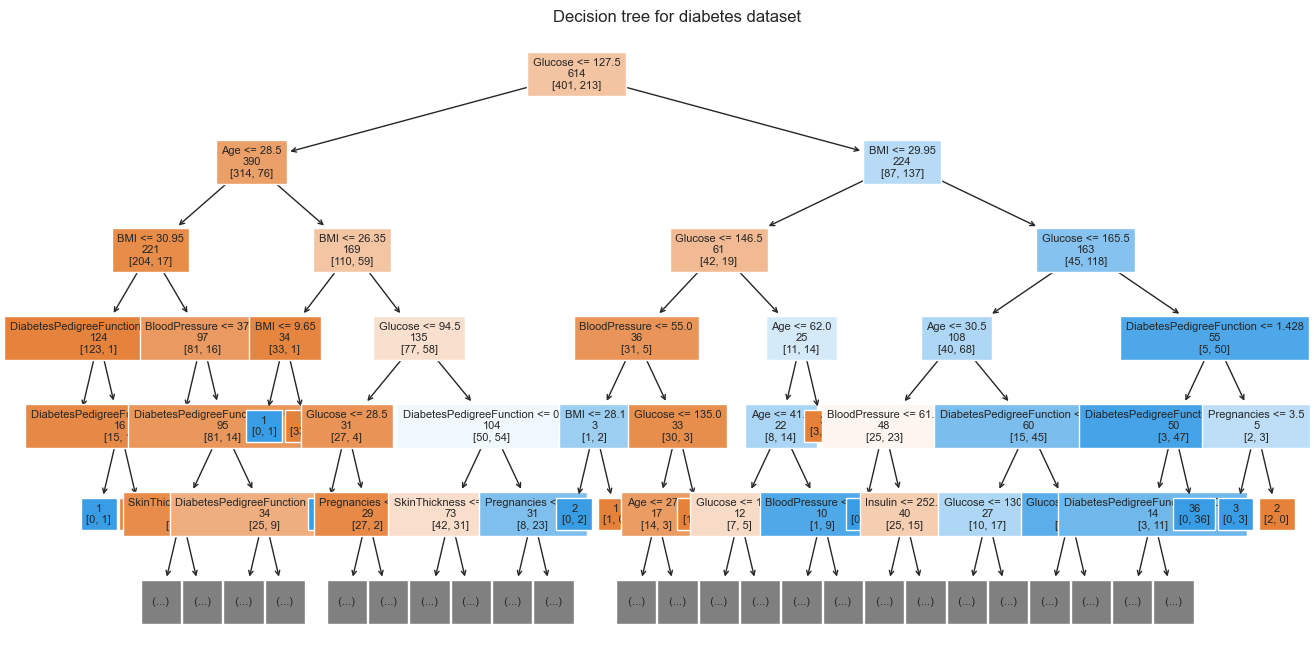

In [28]:
fig, ax = plt.subplots(figsize=(16,8))
plot_tree(tree, filled=True, fontsize=8, max_depth=5, feature_names=list(data.columns), impurity=False, label="none")
plt.title("Decision tree for diabetes dataset")
plt.show()

In [30]:
feature_importance = tree.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

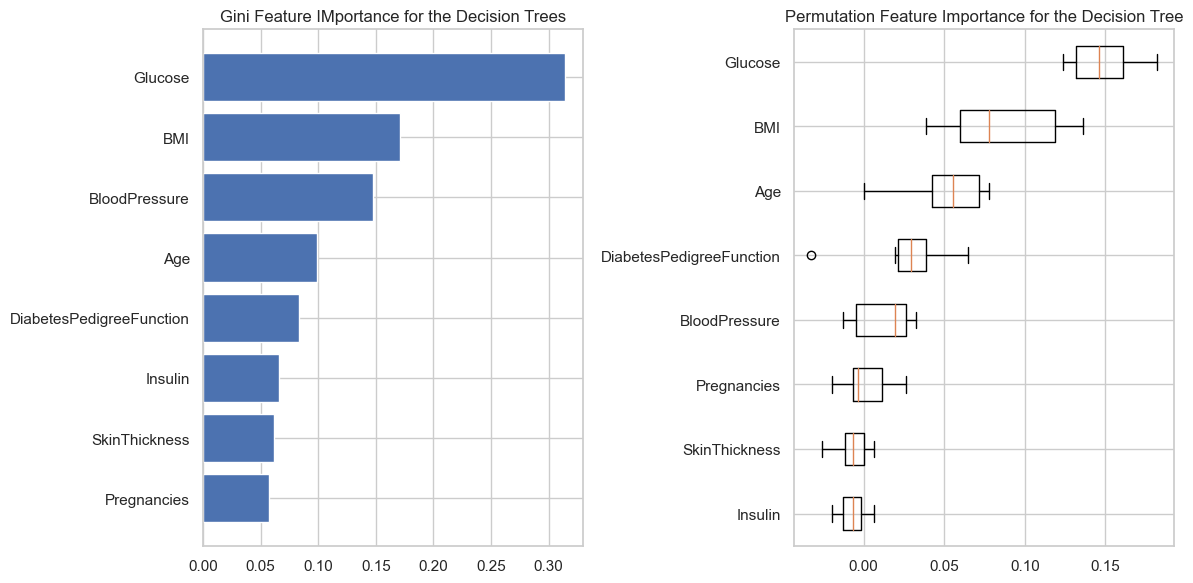

In [43]:
feature_importance = tree.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title("Gini Feature IMportance for the Decision Trees")

result = permutation_importance(tree, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.subplot(1,2,2)
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Feature Importance for the Decision Tree")
fig.tight_layout()
plt.show()

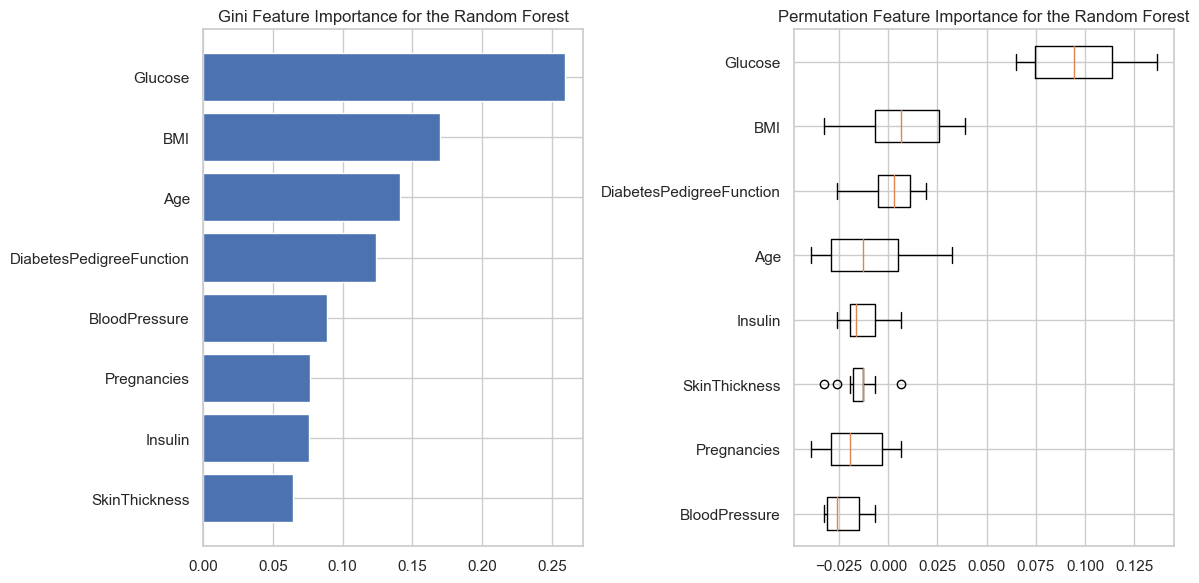

In [48]:
feature_importance = randforest.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(data.columns)[sorted_idx])
plt.title("Gini Feature Importance for the Random Forest")

result = permutation_importance(randforest, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.subplot(1,2,2)
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=np.array(data.columns)[sorted_idx])
plt.title("Permutation Feature Importance for the Random Forest")
fig.tight_layout()
plt.show()

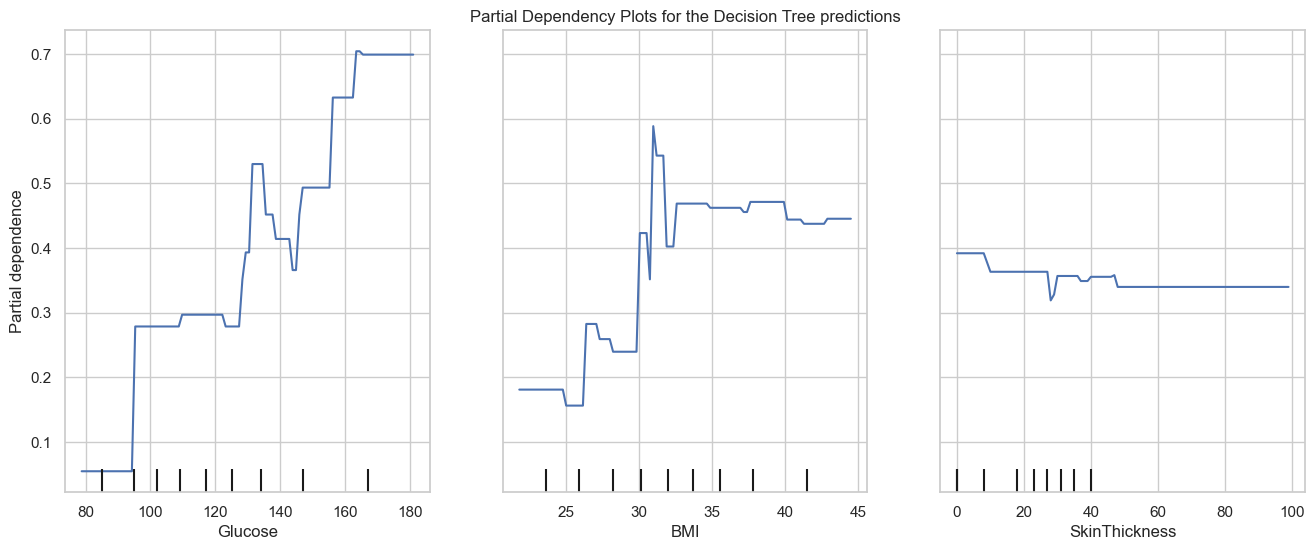

In [55]:
#PDP for the predictions of decision tree
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_title("Partial Dependency Plots for the Decision Tree predictions")

tree_display = PartialDependenceDisplay.from_estimator(tree, X, ["Glucose", "BMI", "SkinThickness"], ax=ax)
plt.show()


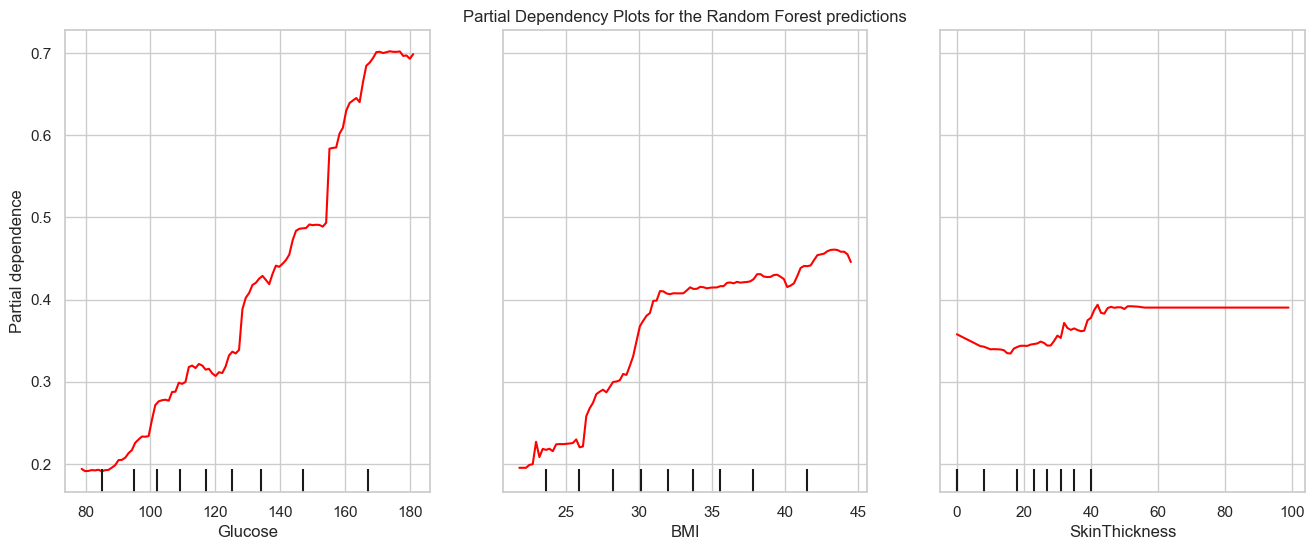

In [56]:
#PDP for predictions of Random Forest

fig, ax = plt.subplots(figsize=(16,6))
ax.set_title("Partial Dependency Plots for the Random Forest predictions")
forest_display = PartialDependenceDisplay.from_estimator(randforest, X, ["Glucose", "BMI", "SkinThickness"],
                                                        ax=ax, line_kw={"color":"red"})

In [73]:
sel_instance = 3
print(tree.classes_)
print(tree.predict_proba(X_test)[sel_instance])

[0 1]
[1. 0.]


In [69]:
#according to the model, the decision tree predicts the positive class with probability one

In [70]:
shap.initjs()
seed = 35

In [86]:
explainer = shap.KernelExplainer(tree.predict_proba, X_train)
shap_values = explainer.shap_values(X_test, nsamples=100)

shap.force_plot(explainer.expected_value[1], shap_values[sel_instance, :, 1], X_test.iloc[sel_instance, :].values)

Using 614 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/154 [00:00<?, ?it/s]

In [89]:
print(randforest.classes_)
print(randforest.predict_proba(X_test)[sel_instance])

[0 1]
[0.75 0.25]


In [90]:
explainer = shap.KernelExplainer(randforest.predict_proba, X_train)
shap_values = explainer.shap_values(X_test, nsamples=100)

shap.force_plot(explainer.expected_value[1], shap_values[sel_instance, :, 1], X_test.iloc[sel_instance, :].values)

Using 614 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/154 [00:00<?, ?it/s]